In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import vmap, jit
import matplotlib.pyplot as plt
import joblib
from qdots_qll.models import game
from qdots_qll import all_funcs
import seaborn as sns
import pandas as pd

In [2]:
run_results = joblib.load("../results/run_2024-01-02_18:33:28_results.job")
run_model = joblib.load("../results/run_2024-01-02_18:33:28_model.job")

In [3]:
true_parameters = game.true_pars
# help(run_model)

In [4]:
run_results

Run(
  iteration=i32[500],
  key=u32[500,2],
  weights=f32[500,2000],
  particles_locations=f32[500,2000,4],
  max_iterations=i32[500],
  min_iterations=i32[500],
  std_threshold=f32[500],
  cov_array=f32[500,4000,4,4],
  estimates_array=f32[500,4000,4]
)

In [6]:
final_cov_matrix = jax.vmap((lambda a, b: a[b]), in_axes=(0, 0))(
    run_results.cov_array, run_results.iteration
)

final_cov_norm = jax.vmap(jnp.linalg.norm, in_axes=(0))(final_cov_matrix)

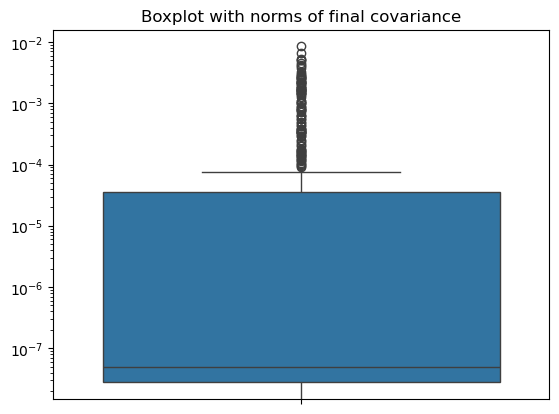

In [244]:
sns.boxplot(y=final_cov_norm)
plt.yscale("log")
plt.title("Boxplot with norms of final covariance")
plt.show()

In [10]:
final_estimates = jax.vmap((lambda a, b: a[b]), in_axes=(0, 0))(
    run_results.estimates_array, run_results.iteration
)

In [34]:
df = pd.DataFrame(final_estimates, columns=["par1", "par2", "par3", "par4"])

df_true_pars = pd.DataFrame(
    true_parameters[np.newaxis, :], columns=["par1", "par2", "par3", "par4"]
)

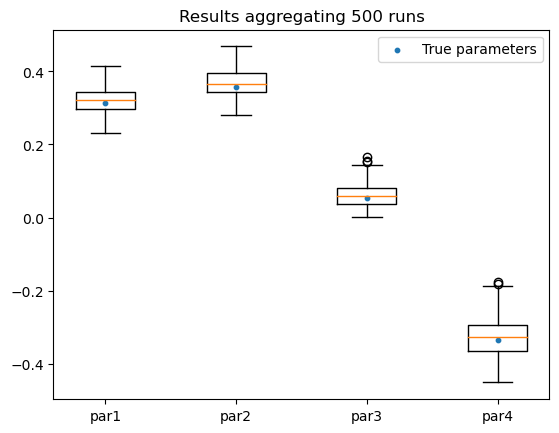

In [125]:
plt.style.use("default")
colnames = ["par1", "par2", "par3", "par4"]
plt.boxplot(df, labels=colnames, positions=range(len(df.columns)))
plt.scatter(
    colnames, true_parameters, label="True parameters", marker="o", s=10
)
# plt.plot(df_true_pars)
plt.title("Results aggregating 500 runs")
plt.legend()
plt.show()

In [131]:
number_of_samples = 500

In [230]:
from scipy.stats import bootstrap

mean = np.array(final_estimates.mean(axis=0))
standard_error_mean = np.array(final_estimates).std(axis=0) / np.sqrt(
    number_of_samples
)

median = np.median(final_estimates, axis=0)


confidence_interval_mean = bootstrap(
    (final_estimates,),
    np.mean,
    confidence_level=0.95,
    random_state=1,
    method="percentile",
    axis=0,
)
bootstrap_ci = bootstrap(
    (final_estimates,),
    np.median,
    confidence_level=0.95,
    random_state=1,
    method="percentile",
    axis=0,
)
standard_error_median = (
    bootstrap_ci.confidence_interval[1] - bootstrap_ci.confidence_interval[0]
) / 3.92

In [239]:
for i in range(4):
    print(f"Parameter {str(i)}:  ")

    print(f"True value: {true_parameters[i]} ")
    print("\n")
    print(f"Mean estimate: {mean[i]:.5f} pm {standard_error_mean[i]:.5f}")
    print(
        f"Median estimate: {median[i]:.5f} pm {standard_error_median[i]:.5f}"
    )
    print("---")
    print(
        f"0.95 Confidence Interval for mean: {confidence_interval_mean.confidence_interval[0][ i]:.5f}, {confidence_interval_mean.confidence_interval[1][  i]:.5f} "
    )
    print(
        f"0.95 Confidence Interval for median: {bootstrap_ci.confidence_interval[0][ i]:.5f}, {bootstrap_ci.confidence_interval[1][  i]:.5f} "
    )
    print("\n")

Parameter 0:  
True value: 0.3142159879207611 


Mean estimate: 0.32137 pm 0.00151
Median estimate: 0.32254 pm 0.00207
---
0.95 Confidence Interval for mean: 0.31849, 0.32428 
0.95 Confidence Interval for median: 0.31806, 0.32616 


Parameter 1:  
True value: 0.35833001136779785 


Mean estimate: 0.36799 pm 0.00169
Median estimate: 0.36649 pm 0.00218
---
0.95 Confidence Interval for mean: 0.36468, 0.37130 
0.95 Confidence Interval for median: 0.36207, 0.37061 


Parameter 2:  
True value: 0.05385100096464157 


Mean estimate: 0.05970 pm 0.00137
Median estimate: 0.05829 pm 0.00190
---
0.95 Confidence Interval for mean: 0.05700, 0.06238 
0.95 Confidence Interval for median: 0.05503, 0.06249 


Parameter 3:  
True value: -0.3336949944496155 


Mean estimate: -0.32731 pm 0.00222
Median estimate: -0.32609 pm 0.00289
---
0.95 Confidence Interval for mean: -0.33170, -0.32299 
0.95 Confidence Interval for median: -0.33183, -0.32051 




<ErrorbarContainer object of 3 artists>

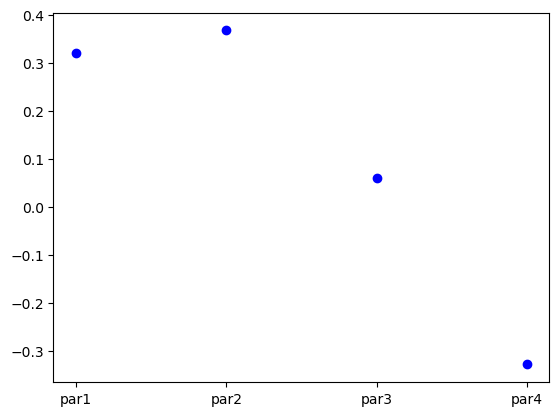

In [210]:
# plt.plot(colnames, mean, marker="o", color="b", linestyle='none')
plt.errorbar(x=colnames, y=mean, yerr=standard_error_mean, fmt="bo")

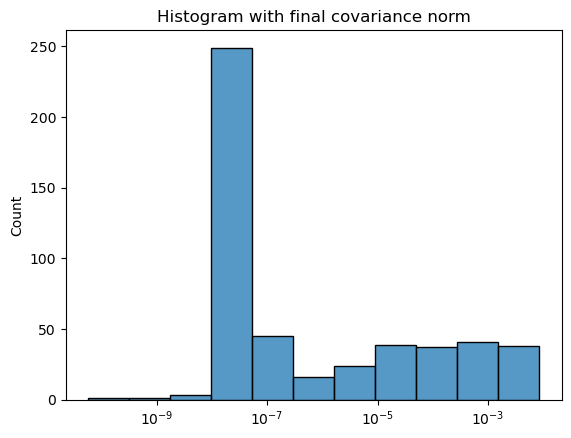

In [241]:
sns.histplot(final_cov_norm, log_scale=True)
plt.title("Histogram with final covariance norm")
plt.show()

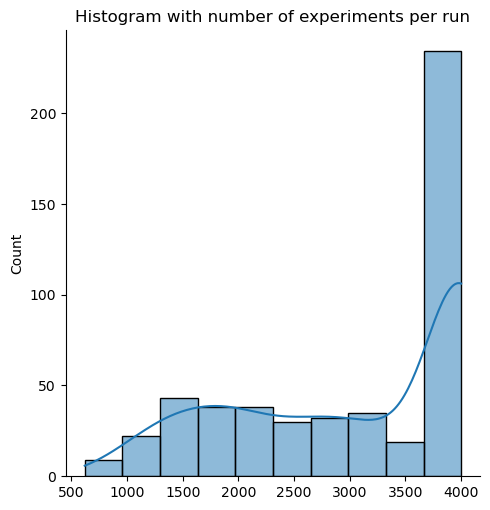

In [242]:
sns.displot(run_results.iteration, kde=True)
plt.title("Histogram with number of experiments per run")
plt.show()